# Ganger Causality for Time Series Causal Discovery

Granger causality can be used for causal discovery in time series data without contemporaneous causal connections. The intuition behind Granger causality is that for two time series random variables $X$ and $Y$, if including the past values of $X$ to predict $Y$ improves the prediction performance, over using only the past values of $Y$, then $X$ causes $Y$. In practice, to find the causal parents of a variable, this algorithm involves performing linear regression to predict that variable using the remaining variables, and using the regression coefficients to determine the causality.

Granger causality assumes: 1. linear relationship between variables, 2. covariance stationary, i.e., a temporal sequence of random variables all have the same mean and the covariance between the random variables at any two time steps depends only on their relative positions, and 3. no hidden confounders.

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pickle as pkl
import time


In [2]:
from causalai.models.time_series.granger import GrangerSingle, Granger

# also importing data object, data transform object, and prior knowledge object, and the graph plotting function
from causalai.data.time_series import TimeSeriesData
from causalai.data.data_generator import DataGenerator, GenerateRandomTimeseriesSEM
from causalai.data.transforms.time_series import StandardizeTransform
from causalai.models.common.prior_knowledge import PriorKnowledge
from causalai.misc.misc import plot_graph, get_precision_recall

## Load and Visualize Data

Load the dataset and visualize the ground truth causal graph. For the purpose of this example, we will use a synthetic dataset available in our repository.

In [3]:
fn = lambda x:x
coef = 0.1
sem = {
        'a': [], 
        'b': [(('a', -1), coef, fn), (('f', -1), coef, fn)], 
        'c': [(('b', -2), coef, fn), (('f', -2), coef, fn)],
        'd': [(('b', -4), coef, fn), (('b', -1), coef, fn), (('g', -1), coef, fn)],
        'e': [(('f', -1), coef, fn)], 
        'f': [],
        'g': [],
        }

T = 5000

# var_names = [str(i) for i in range(6)]
# sem = GenerateRandomTimeseriesSEM(var_names=var_names, max_num_parents=2, seed=1)

data_array, var_names, graph_gt = DataGenerator(sem, T=T, seed=0)
graph_gt

{'a': [],
 'b': [('a', -1), ('f', -1)],
 'c': [('b', -2), ('f', -2)],
 'd': [('b', -4), ('b', -1), ('g', -1)],
 'e': [('f', -1)],
 'f': [],
 'g': []}

Now we perform the following operations:
1. Standardize the data arrays
2. Create the data object

In [4]:


# 1.
StandardizeTransform_ = StandardizeTransform()
StandardizeTransform_.fit(data_array)

data_trans = StandardizeTransform_.transform(data_array)

# 2.
data_obj = TimeSeriesData(data_trans, var_names=var_names)



We visualize the training data below.

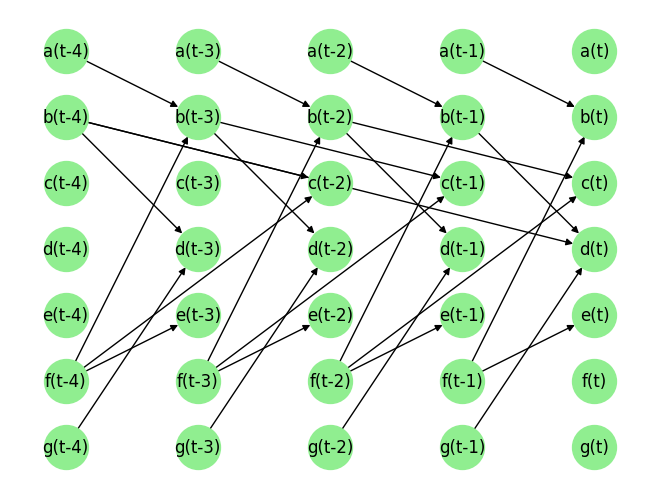

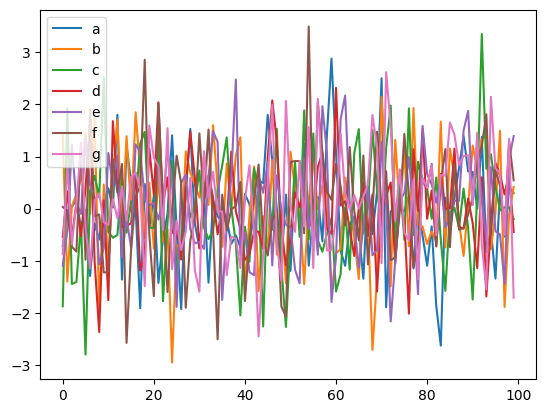

In [5]:


plot_graph(graph_gt, node_size=1000)



for i, n in enumerate(var_names):
    plt.plot(data_trans[-100:,i], label=n)
plt.legend()
plt.legend()
plt.show()

## Causal Discovery (CD)

Our library supports running Granger causal discovery in two modes:

1. Targeted CD: Find causal parents of a single given variable. This is useful when we are only interested in finding out the cause of a specific variable, and not others. We thus save both compute and time this way.
2. Full CD: Find the full causal graph. This is costlier and scales linearly with the number of variables compared to the time taken by the mode above.

Enable/Disable Parallel Processing:

Before we instantiate our causal discovery model, we need to decide if we want to use multi-processing. Multi-processing typically provides a significant speed-up for the PC algorithm, but does not provide much advantage for Granger causality because it is already a light weight algorithm, unless the number of variables or samples is very large. In order to use multi-processing in our causal discovery library, we pass the argument use_multiprocessing=True to the model constructor. It's default value is False.



### Targeted Causal Discovery

In [6]:


prior_knowledge = None # PriorKnowledge(forbidden_links={'a': ['b']})

target_var = 'b'
max_lag = 4
pvalue_thres = 0.05
print(f'Target Variable: {target_var}, using max_lag {max_lag}, pvalue_thres {pvalue_thres}')

granger_single = GrangerSingle(
    data=data_obj,
    prior_knowledge=prior_knowledge,
    max_iter=1000, # number of optimization iterations for model fitting (default value is 1000)
    use_multiprocessing=False
    )


Target Variable: b, using max_lag 4, pvalue_thres 0.05


In [7]:
tic = time.time()
result = granger_single.run(target_var=target_var, pvalue_thres=pvalue_thres, max_lag=max_lag)

toc = time.time()
print(f'Time taken: {toc-tic:.2f}s\n')

for key in result.keys():
    print(key, '\n', result[key])
    print()


Time taken: 0.09s

parents 
 [('f', -1), ('a', -1)]

value_dict 
 {('a', -1): 0.06738488546606494, ('a', -2): 0.0, ('a', -3): 0.0, ('a', -4): 0.0, ('b', -1): 0.0, ('b', -2): 0.0, ('b', -3): -0.0, ('b', -4): -0.006938587216147953, ('c', -1): -0.0, ('c', -2): 0.0, ('c', -3): 0.0, ('c', -4): 0.0, ('d', -1): 0.0, ('d', -2): 0.0, ('d', -3): -0.0, ('d', -4): 0.0, ('e', -1): -0.0, ('e', -2): 0.0018099624305629443, ('e', -3): 0.0, ('e', -4): 0.0, ('f', -1): 0.08500800021771439, ('f', -2): 0.0, ('f', -3): 0.0, ('f', -4): 0.0, ('g', -1): 0.0, ('g', -2): -0.0, ('g', -3): -0.0, ('g', -4): 0.0}

pvalue_dict 
 {('a', -1): 1.7511628236742058e-06, ('a', -2): 1.0, ('a', -3): 1.0, ('a', -4): 1.0, ('b', -1): 1.0, ('b', -2): 1.0, ('b', -3): 1.0, ('b', -4): 0.6256123328298466, ('c', -1): 1.0, ('c', -2): 1.0, ('c', -3): 1.0, ('c', -4): 1.0, ('d', -1): 1.0, ('d', -2): 1.0, ('d', -3): 1.0, ('d', -4): 1.0, ('e', -1): 1.0, ('e', -2): 0.8981369488649764, ('e', -3): 1.0, ('e', -4): 1.0, ('f', -1): 1.7218673803622

The output variable result is a dictionary with 3 keys, _parents_, _value\_dict_ and _pvalue\_dict_. The first one is a list of the causal parents. Each of latter ones is a dictionary, with keys equal to all possile candidates of the specified target variable. On a side note, note that if any links are specified as forbidden in prior_knowledge, they will be ignored during the computation and will not be present in result.

The dictionary result['value_dict'] contains the strength of the link between the targeted variable and each of the candidate parents. The dictionary result['pvalue_dict'] contains the p-values of the said strength. 

In [8]:

print(f'Predicted parents:')
parents = result['parents']
print(parents)

print(f"Ground truth parents:")
print(graph_gt[target_var])

Predicted parents:
[('f', -1), ('a', -1)]
Ground truth parents:
[('a', -1), ('f', -1)]


### Full Causal Discovery

In [9]:


prior_knowledge = None #  PriorKnowledge(forbidden_links={'a': ['b']})

max_lag = 4
print(f'Using max_lag {max_lag}')

granger = Granger(
        data=data_obj,
        prior_knowledge=prior_knowledge,
        max_iter=1000, # number of optimization iterations for model fitting (default value is 1000)
        use_multiprocessing=False
        )


Using max_lag 4


In [10]:
tic = time.time()
result = granger.run(max_lag=max_lag)
toc = time.time()
print(f'Time taken: {toc-tic:.2f}s\n')


print(f' The output causal_strength has keys: {result.keys()}')

Time taken: 0.55s

 The output causal_strength has keys: dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g'])


In [11]:
print(f'Predicted parents:')
graph_est={n:[] for n in result.keys()}
for key in result.keys():
    parents = result[key]['parents']
    graph_est[key].extend(parents)
    print(f'{key}: {parents}')

print(f"\nGround truth parents:")  
for key in graph_gt.keys():
    print(f'{key}: {graph_gt[key]}')
    
precision, recall, f1_score = get_precision_recall(graph_est, graph_gt)
print(f'Precision {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1_score:.2f}')

Predicted parents:
a: []
b: [('f', -1), ('a', -1)]
c: [('b', -2), ('f', -2)]
d: [('g', -1), ('b', -4), ('b', -1)]
e: [('f', -1)]
f: []
g: []

Ground truth parents:
a: []
b: [('a', -1), ('f', -1)]
c: [('b', -2), ('f', -2)]
d: [('b', -4), ('b', -1), ('g', -1)]
e: [('f', -1)]
f: []
g: []
Precision 1.00, Recall: 1.00, F1 score: 1.00
